In [1]:
import pandas as pd
import numpy as np
import os
import re

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.chdir('/shared/0/projects/research-jam-summer-2024/')

In [96]:
#base_dir = 'data/english_only/prompting_results_clean/with_metrics/' #experiment 1
base_dir = 'data/english_only/100k_results/with_metrics/' #experiment 2

In [97]:
for f in os.listdir(base_dir):
    if f.startswith('wildchat_subset_en_100k_') and not f.endswith('_end.jsonl'):
        print(f)
    else: 
        print('NOT:',f)

NOT: wildchat_subset_en_100k_Mixtral-8x7B_end.jsonl
wildchat_subset_en_100k_Mixtral-8x7B_embeddings.npz
NOT: human-turn1.grammar-tool-output.csv
wildchat_subset_en_100k_Mistral-Large-Instruct.jsonl
NOT: wildchat_subset_en_100k_Mistral-Large-Instruct_end.jsonl
wildchat_subset_en_100k_Mistral-Large-Instruct_individual.jsonl
wildchat_subset_en_100k_Mistral-Large-Instruct_embeddings.npz
NOT: wildchat_subset_en_100k_Llama-3.1-70B_end.jsonl
wildchat_subset_en_100k_Mixtral-8x7B.jsonl
wildchat_subset_en_100k_Llama-3.1-70B.jsonl
wildchat_subset_en_100k_Llama-3.1-70B_embeddings.npz


In [84]:
f = 'wildchat_subset_en_2k_prompting_Qwen2-72B-Instruct_POS_DEP.jsonl'
syn = make_df(f)
syn[['human_dep_dpth','human_dep_brth','human_dep_avg_brth',
     'llm_dep_dpth','llm_dep_brth','llm_dep_avg_brth',
     'spacy_pos']]

,human_dep_dpth,human_dep_brth,human_dep_avg_brth,llm_dep_dpth,llm_dep_brth,llm_dep_avg_brth,spacy_pos
0,1,3,0.750000,4,7,0.907407,0.406045
1,1,3,0.750000,3,4,0.818182,0.331162
2,1,3,0.750000,6,5,0.912281,0.456576
3,1,3,0.750000,5,5,0.901961,0.407891
4,1,3,0.750000,8,6,0.942149,0.443783
...,...,...,...,...,...,...,...
91995,1,3,0.750000,9,10,0.949239,0.447142
91996,1,3,0.750000,14,11,0.962264,0.439102
91997,6,5,0.965517,10,8,0.963542,0.694387
91998,1,3,0.750000,6,6,0.919463,0.422821


<Axes: xlabel='human_dep_avg_brth', ylabel='Count'>

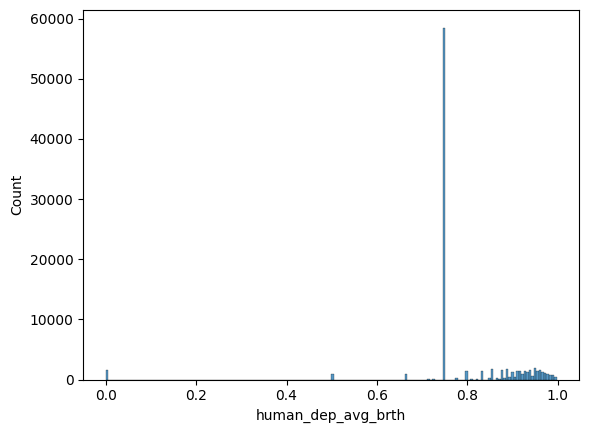

In [95]:
sns.histplot(syn['human_dep_avg_brth'])

/opt/anaconda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='llm_dep_dpth', ylabel='Count'>

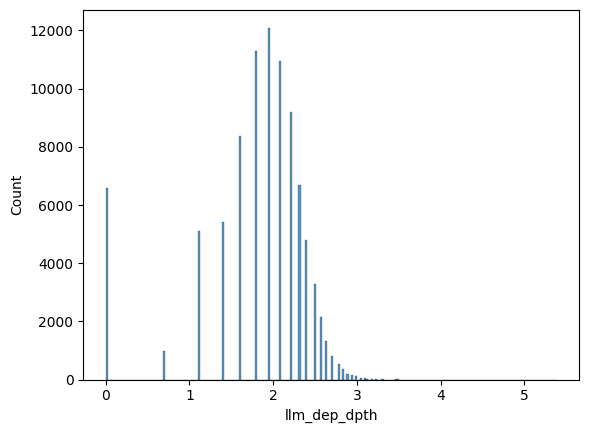

In [94]:
sns.histplot(np.log(syn['llm_dep_dpth']))

In [5]:
def make_df(f):
    df = pd.read_json(base_dir+f, orient='records', lines=True)
    df['model'] = f
    return df

In [6]:
metrics = []
for f in os.listdir(base_dir):
    if f.startswith('wildchat_subset_en_100k_') and not f.endswith('_end.jsonl'):
        metrics.append(make_df(f))
metrics = pd.concat(metrics).reset_index(drop=True)


In [7]:
from copy import deepcopy
metrics_orig = deepcopy(metrics)

In [8]:
metrics['metric_perplexity'] = (1 - 1/metrics['llm_perplexity']) - (1 - 1/metrics['human_perplexity'])

In [9]:
metrics['human_readability'] = metrics['human_readability'].replace(-1, np.NaN)
metrics['llm_readability'] = metrics['llm_readability'].replace(-1, np.NaN)
metrics['metric_readability'] = metrics['llm_readability'] - metrics['human_readability']


In [10]:
def capital_rate(text):
    # count number of capital letters
    capital_count = sum(1 for char in text if char.isupper())

    # count number of aplhabet letters (i.e., letters that can be capitalized)
    total_letter_count = sum(1 for char in text if char.isalpha())

    if total_letter_count > 0:
        return capital_count / total_letter_count
    else:
        return np.nan

# calculate capital rate for human and ai
metrics['human_capitalization'] = metrics['human_turn_3'].apply(capital_rate)
metrics['llm_capitalization'] = metrics['llm_turn_3'].apply(capital_rate)
metrics['metric_capitalization'] = metrics['llm_capitalization'] - metrics['human_capitalization']

In [11]:
import string
search_string = '|'.join([letter+letter+letter 
          for letters in [list(string.ascii_lowercase), list(string.ascii_uppercase)] for letter in letters])
def is_elongated_word(word):
    return bool(re.search(search_string, word))
def frac_elongated_words(utterance):
    return np.mean([1 if is_elongated_word(word) else 0 for word in utterance.split()])
    
metrics['human_elongation'] = metrics['human_turn_3'].apply(frac_elongated_words)
metrics['llm_elongation'] = metrics['llm_turn_3'].apply(is_elongated_word)
metrics['metric_elongation'] = metrics['llm_elongation'] - metrics['human_elongation']

<Axes: xlabel='metric_elongation', ylabel='Count'>

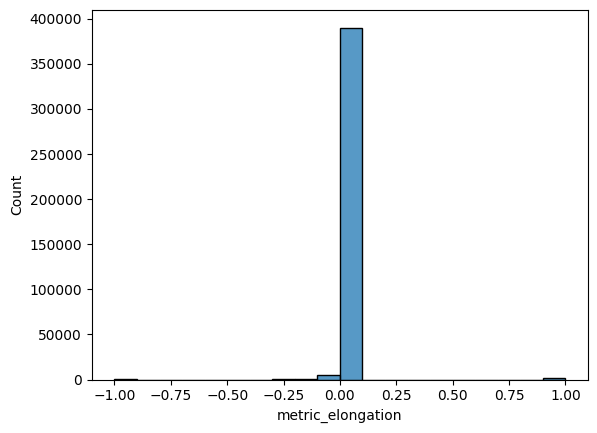

In [12]:
sns.histplot(metrics['metric_elongation'])

In [13]:
import json

contractions_dict = json.load(open('data/contractions_dict.json','r'))
def get_contract_count(text):
    return np.mean([1 if word in contractions_dict or word.lower() in contractions_dict else 0 
                    for word in text.split()])


metrics['human_contract_count'] = metrics.human_turn_3.apply(get_contract_count)
metrics['llm_contract_count'] = metrics.llm_turn_3.apply(get_contract_count)
metrics['metric_contract_count'] = 1 - np.abs(metrics['llm_contract_count'] - metrics['human_contract_count'])

/opt/anaconda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
metrics = metrics[metrics.llm_turn_3.apply(lambda x: re.sub('\s|\n|\r','',x)!='')]

In [15]:
def get_word_length(utterance):
    return np.mean([len(word) for word in utterance.split()])
metrics['human_log_word_length'] = np.log(metrics.human_turn_3.apply(get_word_length))
metrics['llm_log_word_length'] = np.log(metrics.llm_turn_3.apply(get_word_length))
metrics['metric_log_word_length'] = metrics['llm_log_word_length'] - metrics['human_log_word_length']

In [16]:
metrics.shape

(397174, 106)

In [17]:
Counter(metrics.human_turn_1.isna())

Counter({False: 397174})

In [18]:
Counter(metrics[metrics.human_turn_1.isna()].model)

Counter()

In [19]:
metrics = metrics[~metrics.human_turn_1.isna()]

In [20]:
[c for c in metrics.columns if c.startswith('metric')]

['metric_bleu',
 'metric_capitalization',
 'metric_contract_count',
 'metric_end',
 'metric_factuality',
 'metric_formality',
 'metric_liwc',
 'metric_log_word_count',
 'metric_luar',
 'metric_perplexity',
 'metric_politeness',
 'metric_pos',
 'metric_punctuation',
 'metric_readability',
 'metric_rouge',
 'metric_sbert',
 'metric_sentiment',
 'metric_subjectivity',
 'metric_topic',
 'metric_toxicity',
 'metric_typo',
 'metric_word_length',
 'metric_elongation',
 'metric_log_word_length']

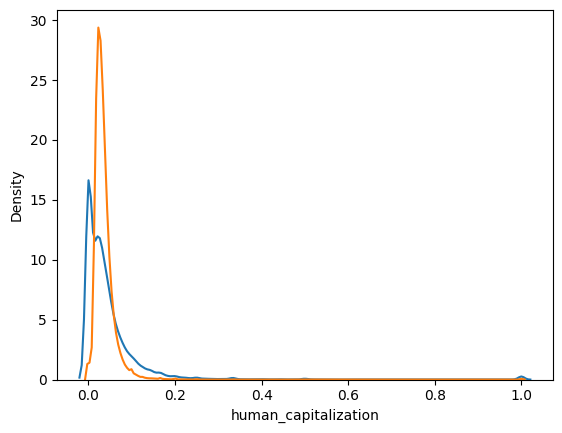

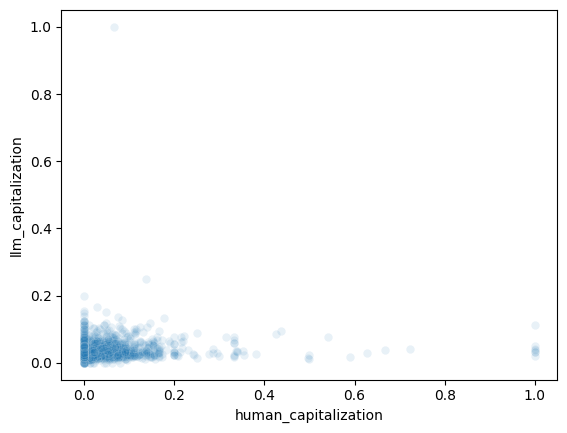

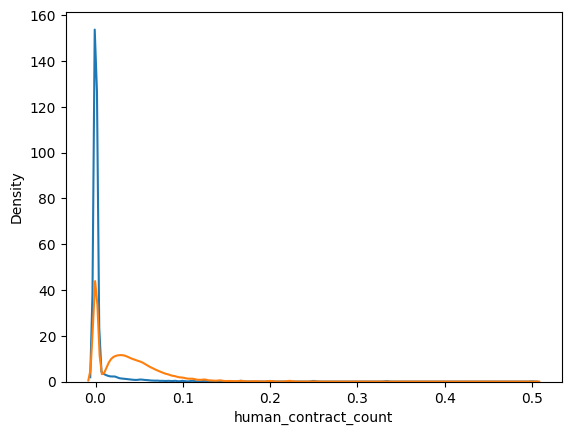

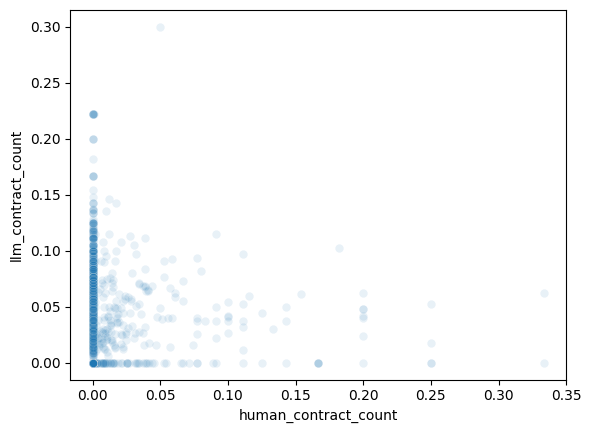

/tmp/ipykernel_3051810/2771400068.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(metrics[c]) #blue line human
/tmp/ipykernel_3051810/2771400068.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(metrics[re.sub('human_','llm_',c)]) #orange line llm


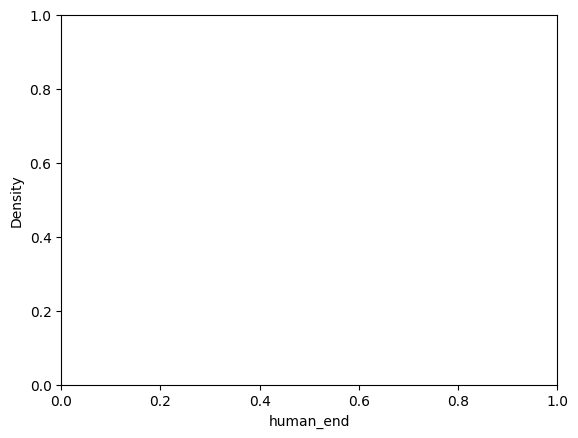

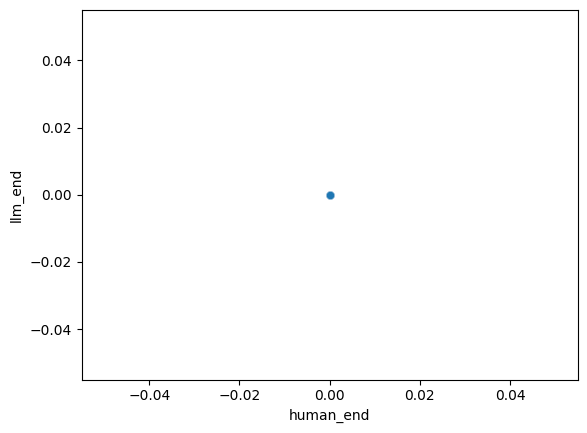

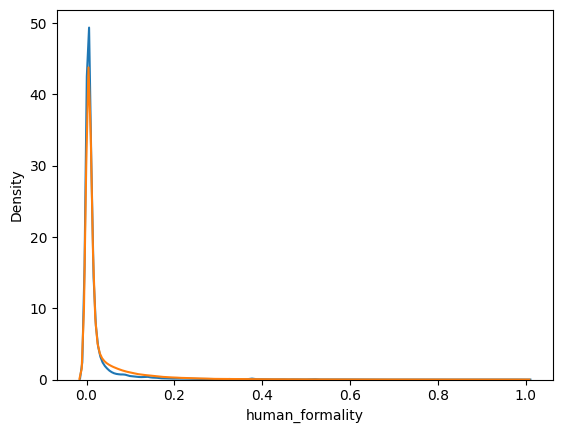

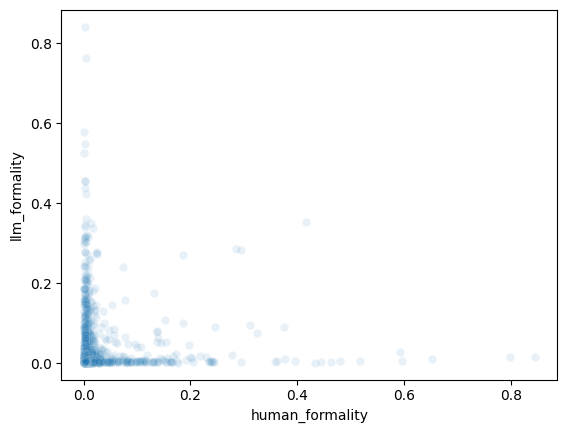

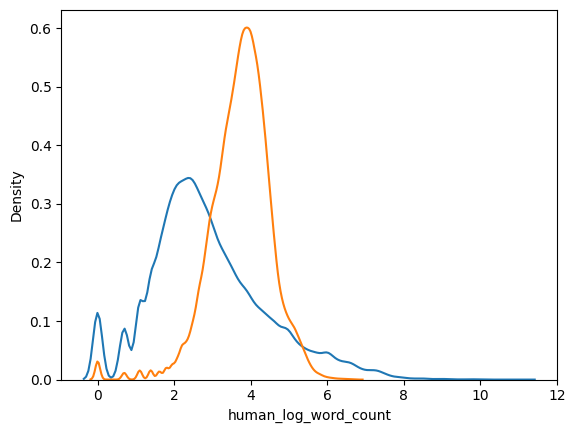

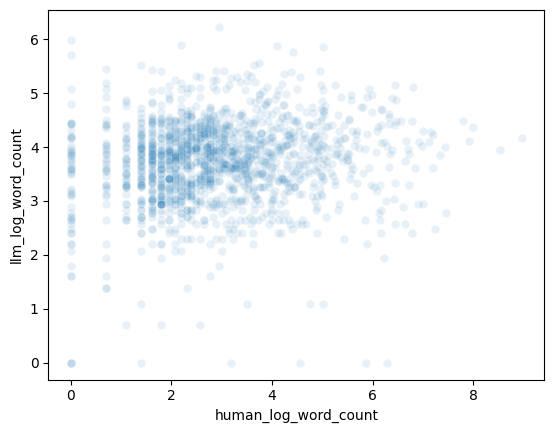

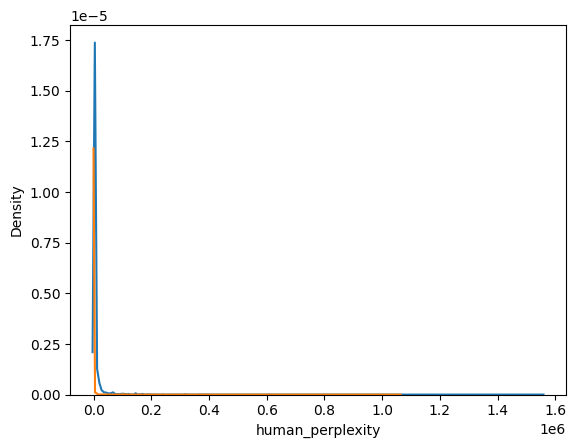

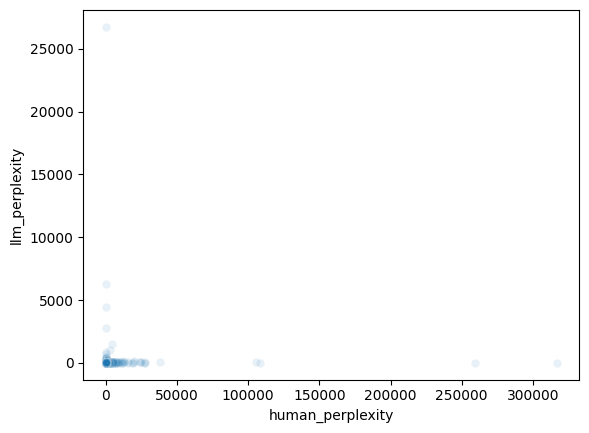

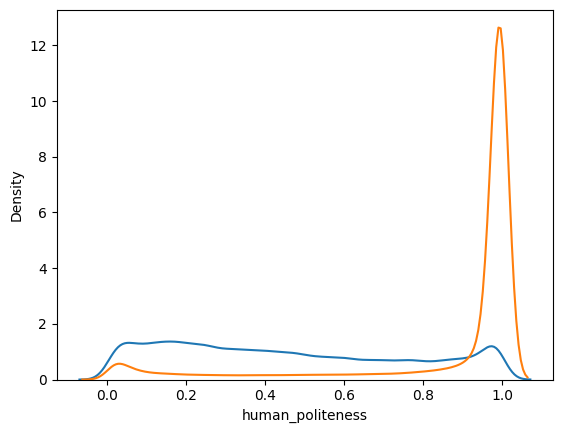

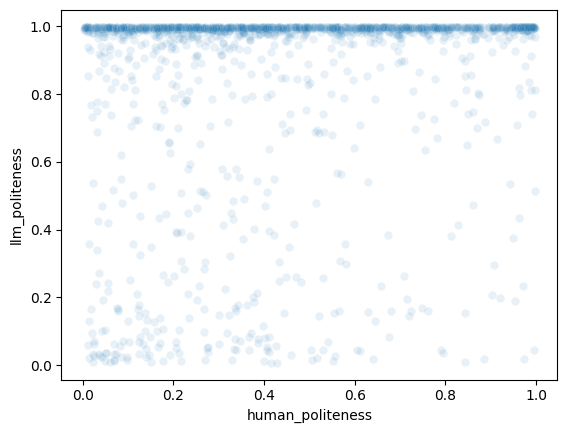

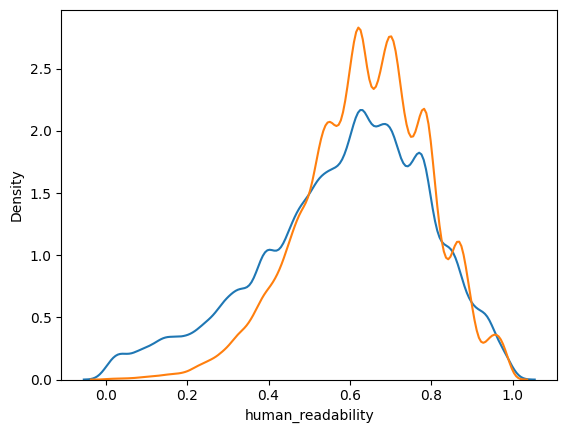

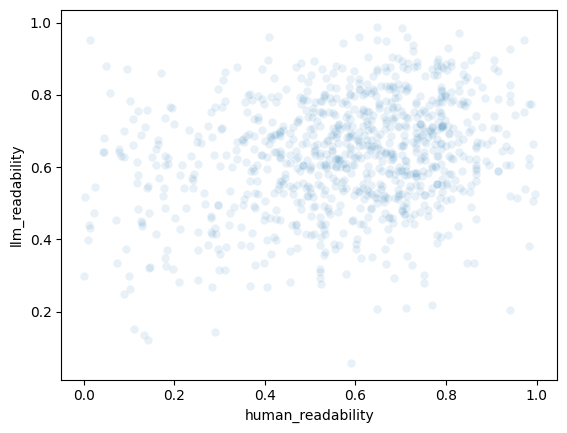

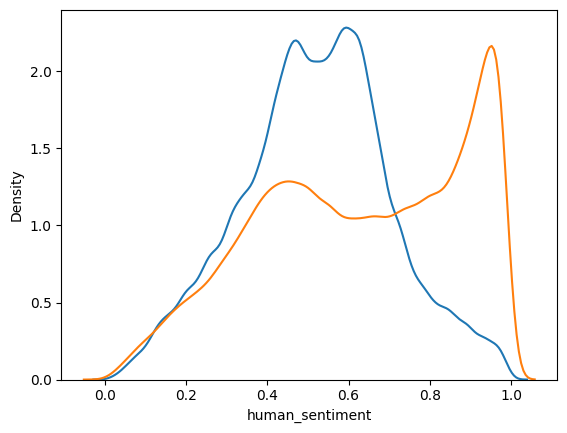

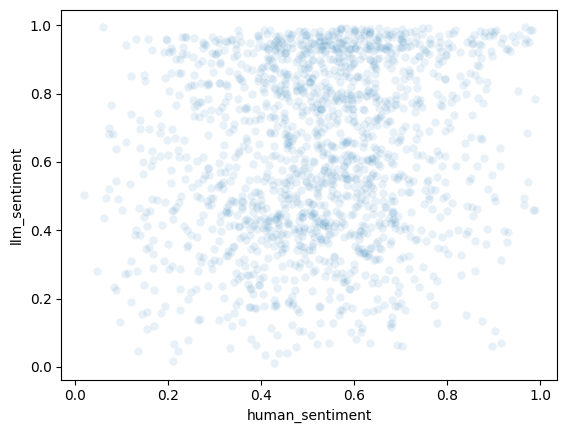

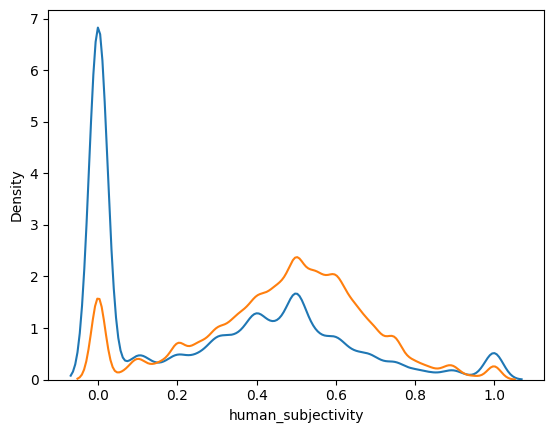

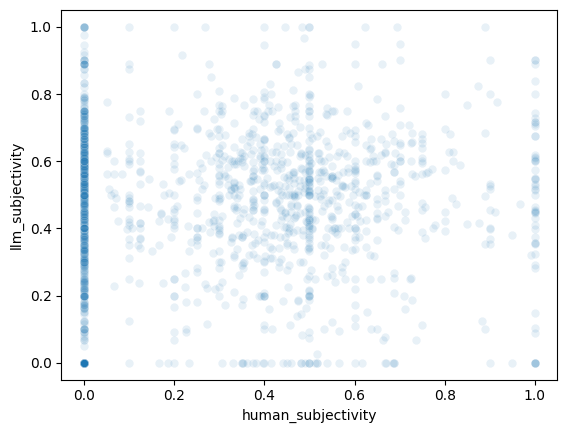

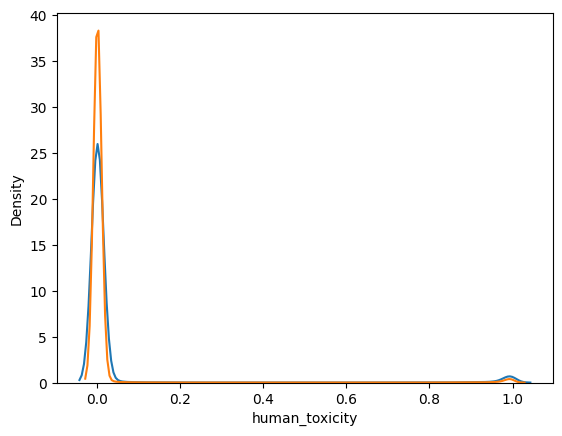

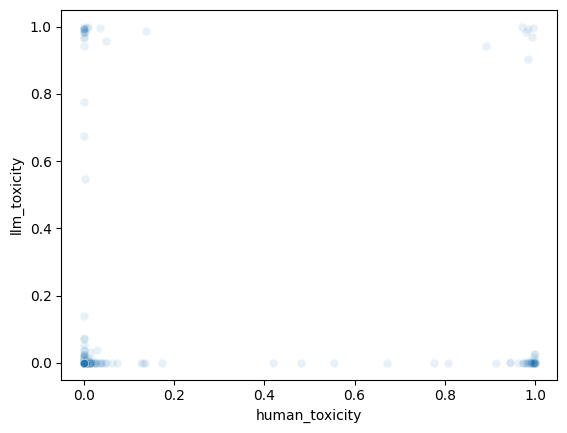

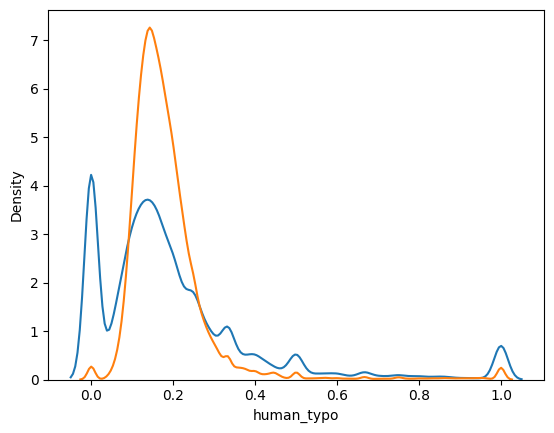

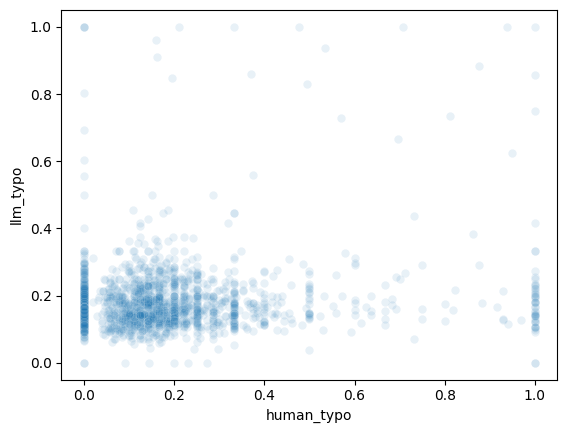

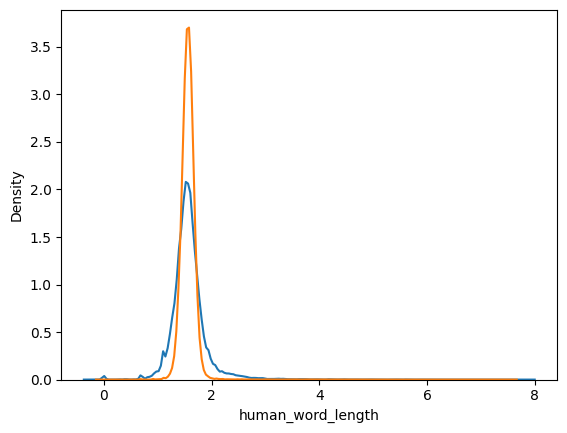

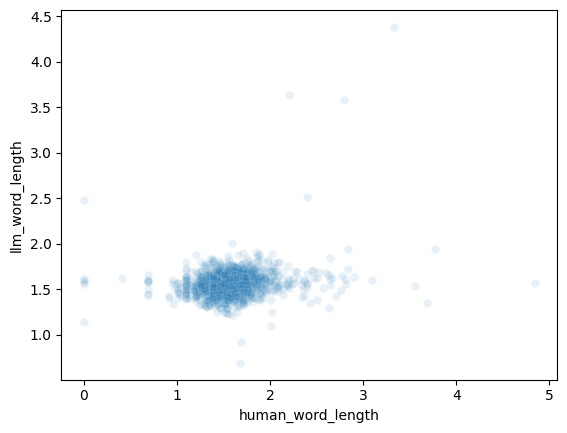

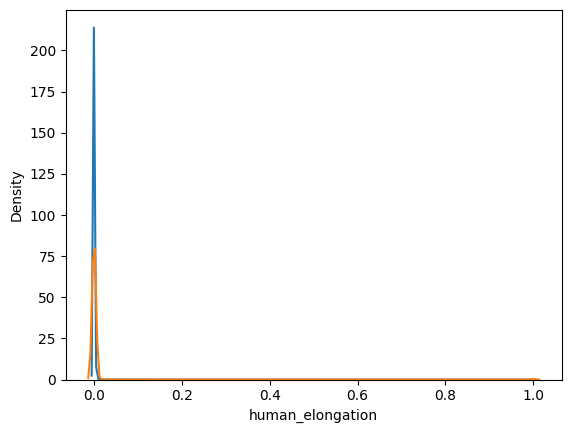

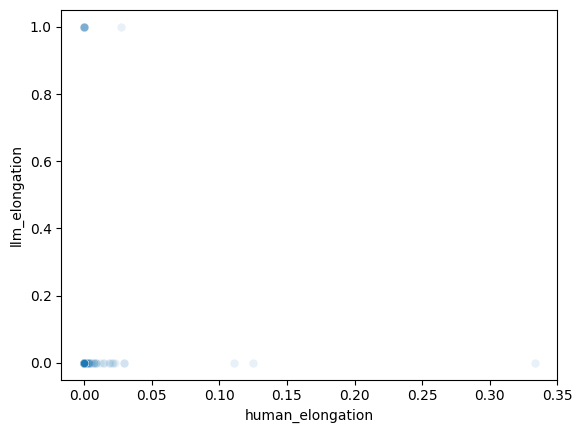

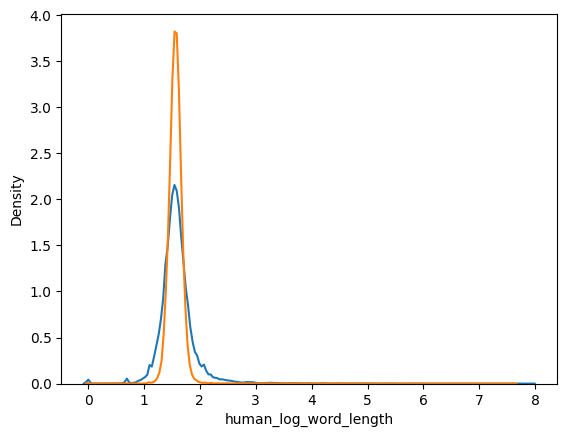

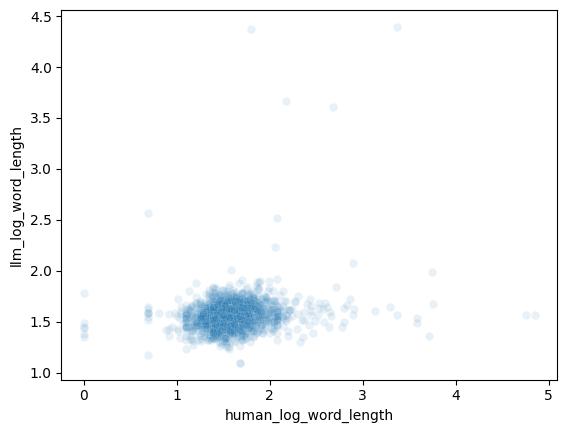

In [71]:
# Compare human and llm for scalars
from pandas.api.types import is_numeric_dtype
import random
inds = random.sample(list(metrics.index), 2000)
for c in metrics.columns:
    if c.startswith('human_'):
        if not 'turn' in c:
            if is_numeric_dtype(metrics[c]):
                sns.kdeplot(metrics[c]) #blue line human
                sns.kdeplot(metrics[re.sub('human_','llm_',c)]) #orange line llm
                plt.show()
                
                sns.scatterplot(data = metrics.iloc[inds], x = c, y = re.sub('human_','llm_',c), alpha = 0.1)
                plt.show()

In [21]:
def normalize(x, method = 'minmax', center = True, pos_scale = True, remove_outlier='none'):
    x_norm = x
    
    if method == 'zscore':
        if remove_outlier == 'IQR':
            q1 = np.percentile(x_norm, 25)
            q3 = np.percentile(x_norm, 75)
            iqr = q3 - q1
            lower = q1 - 1.5*iqr
            upper = q3 + 1.5*iqr
            x_norm[x_norm < lower] = lower
            x_norm[x_norm > upper] = upper
        
        if center: x_norm = x_norm - np.mean(x_norm)
        x_norm = x_norm / np.std(x_norm)
        
    if method == 'minmax':
#         if remove_outlier == 'percentile_99':
#             quantile = [i/len(x_norm) for i in sorted(range(len(x_norm)), key=x_norm.__getitem__)]
#             x_norm = [np.percentile(x_norm, 0.5) if quantile[i]<0.005 
#                       else np.percentile(x_norm, 99.5) if quantile[i]>0.995 
#                       else x_norm[i] for i in range(len(x_norm))]

        min_val = min(x_norm)
        max_val = max(x_norm)
        if pos_scale: x_norm = (x_norm - min_val)/(max_val - min_val)
        else: x_norm = 2*(x_norm - min_val)/(max_val - min_val) - 1
            
#         if remove_outlier == 'percentile_99':
#             x_norm = x_norm * 0.99 + 0.005
#             x_norm = [quantile[i] if quantile[i]<0.005 or quantile[i]>0.995 
#                       else x_norm[i] for i in range(len(x_norm))]
            
    return x_norm

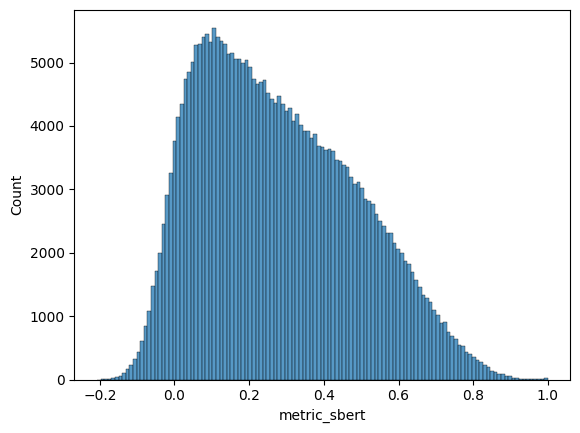

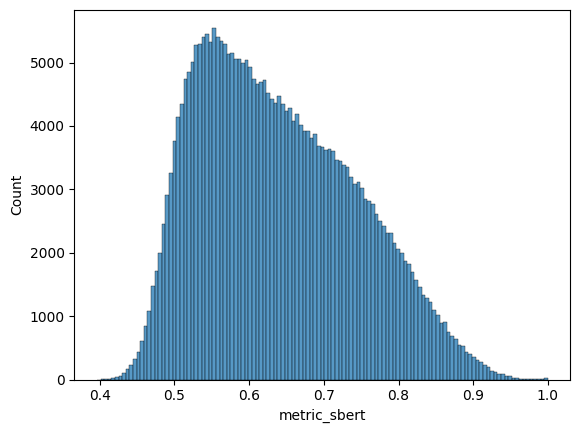

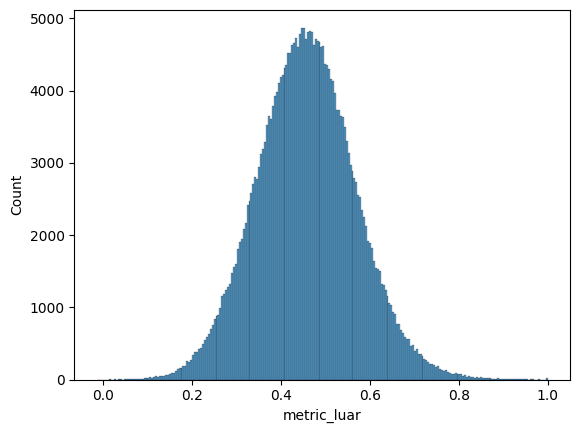

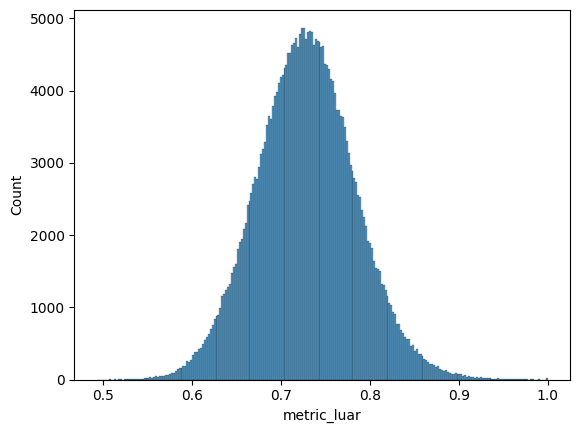

In [22]:
#min-max normalize cosine similarity (-1 to 1 scale)
for c in ['metric_sbert','metric_luar']:
    sns.histplot(metrics[c])
    plt.show()
    metrics[c] = (metrics[c]+1)/2
    sns.histplot(metrics[c])
    plt.show()


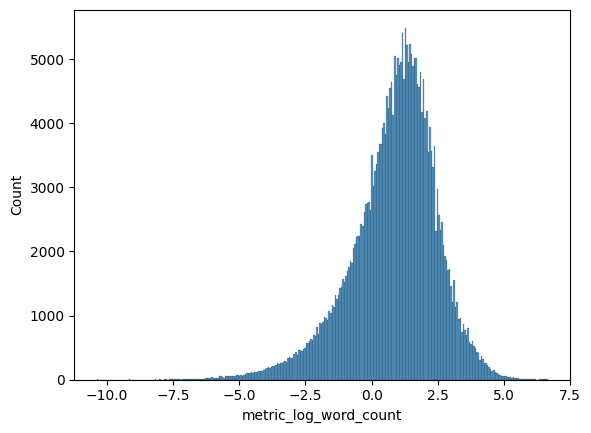

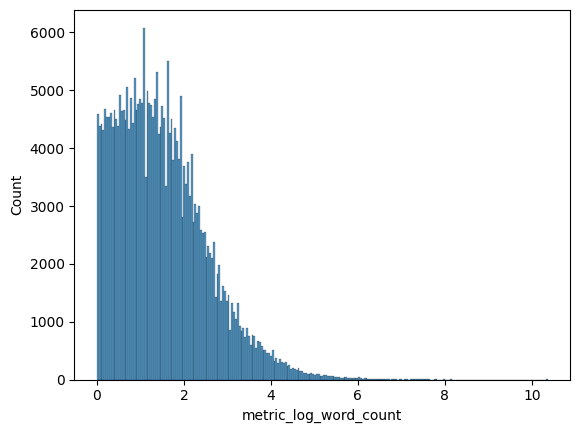

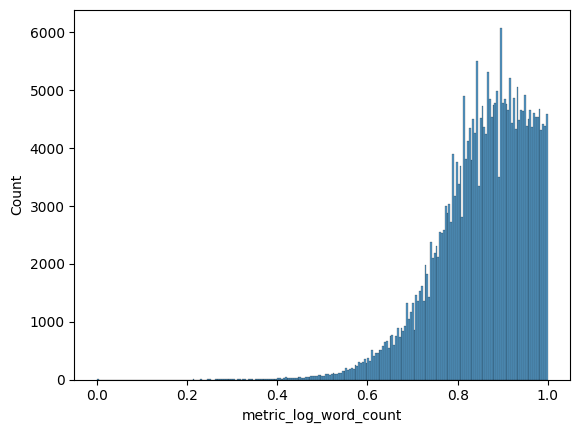

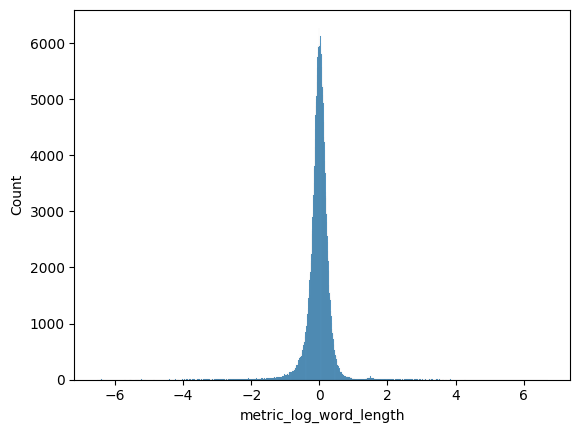

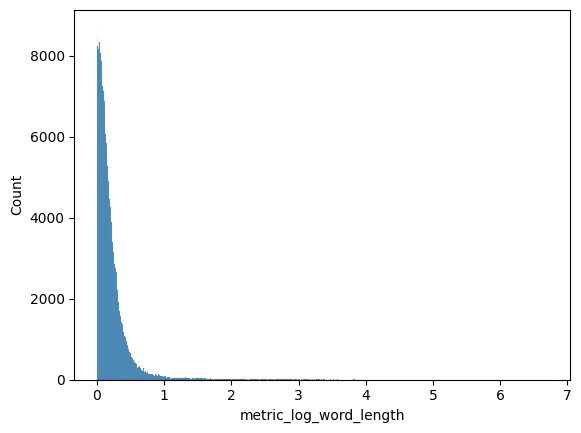

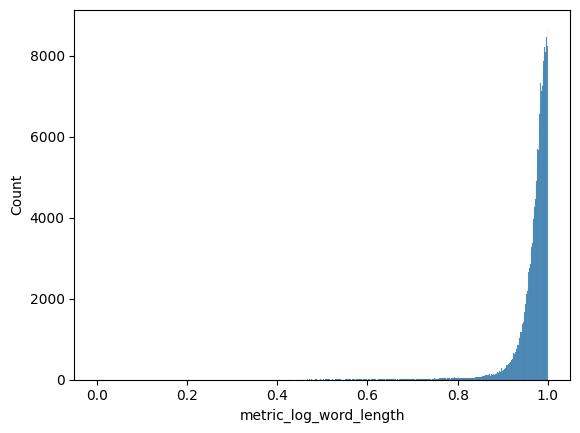

In [23]:
#min-max normalize count data
needs_normalization = ['metric_log_word_count', 'metric_log_word_length']
for c in needs_normalization:
    sns.histplot(metrics[c])
    plt.show()
    sns.histplot(metrics[c].abs())
    plt.show()
    metrics[c] = 1-normalize(metrics[c].abs())
    sns.histplot(metrics[c])
    plt.show()


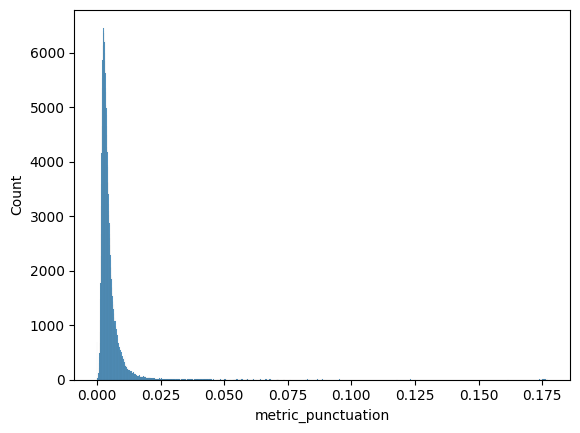

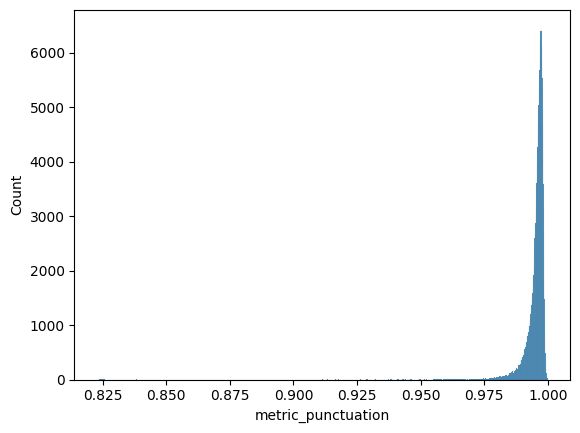

In [24]:
# Turn RMSE to similarity with 1-x
for c in ['metric_punctuation']:
    sns.histplot(metrics[c])
    plt.show()
    metrics[c] = 1 - metrics[c]
    sns.histplot(metrics[c])
    plt.show()

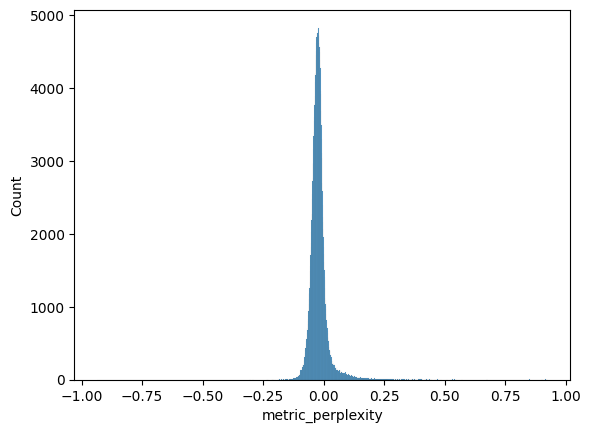

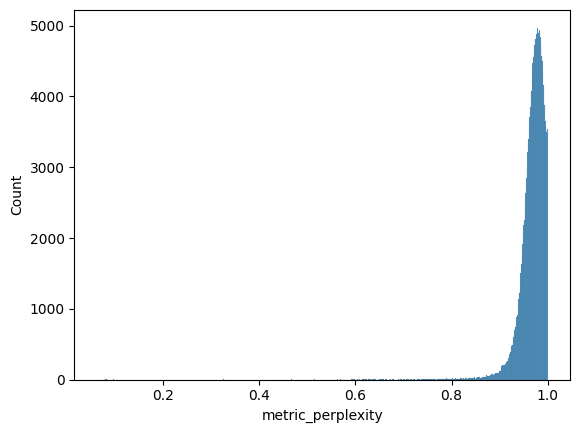

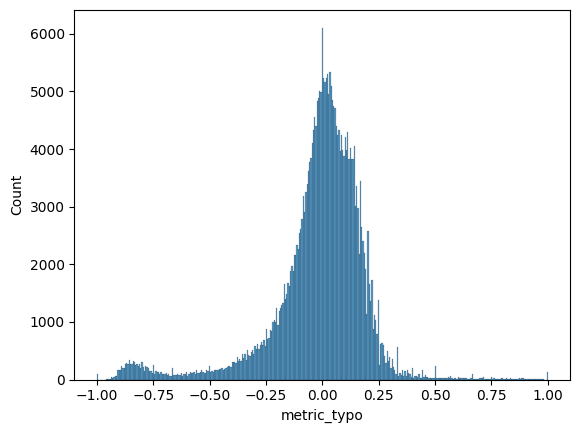

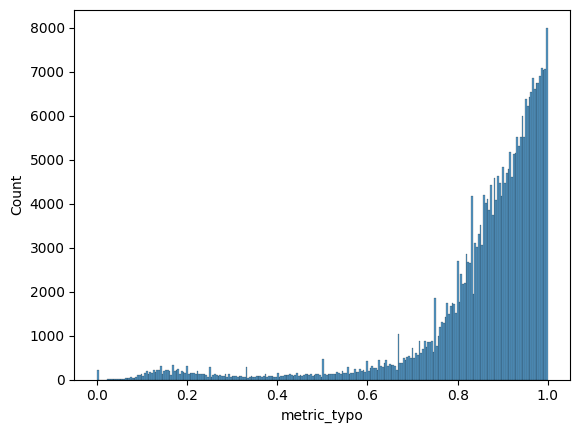

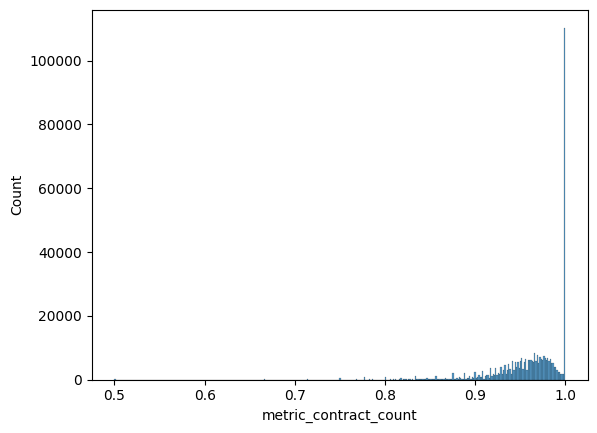

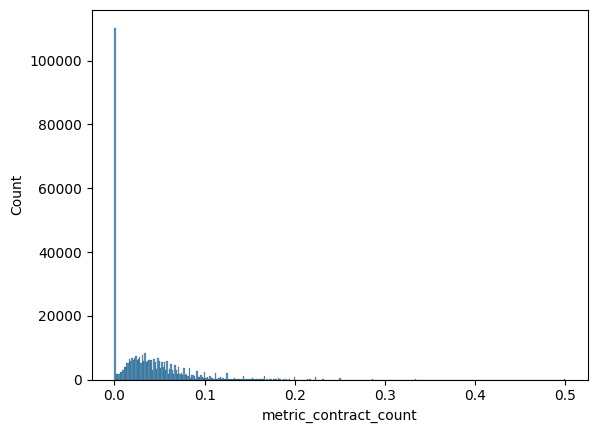

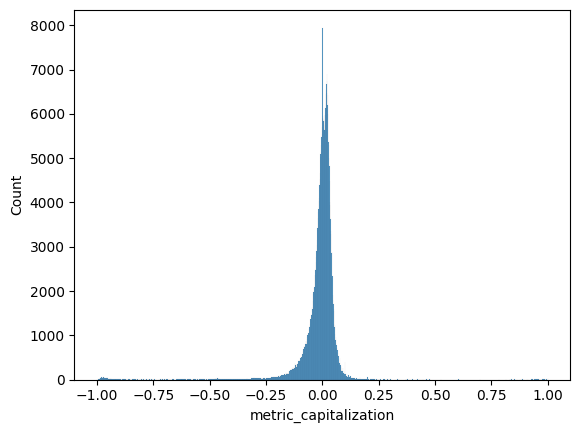

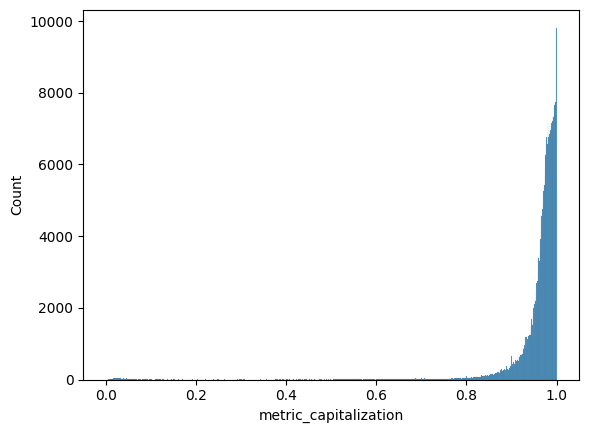

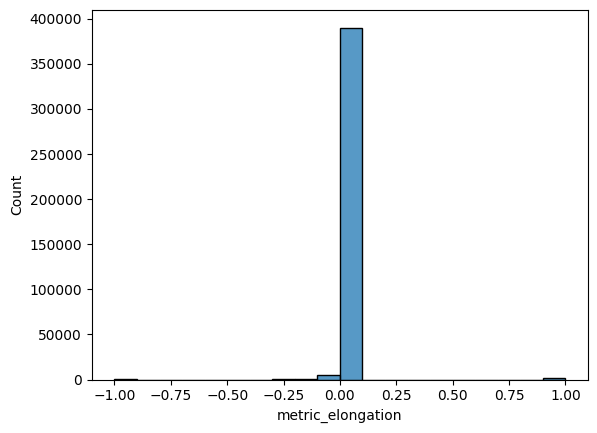

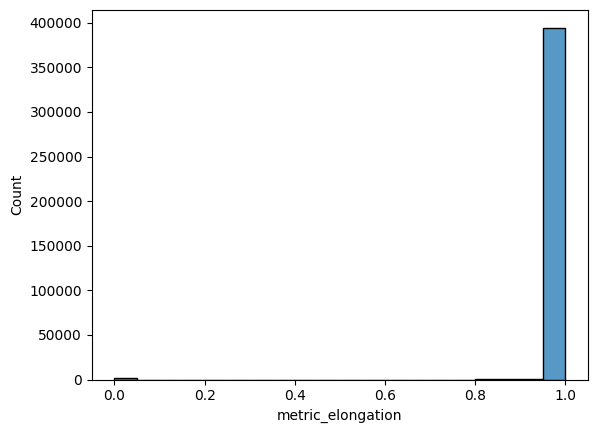

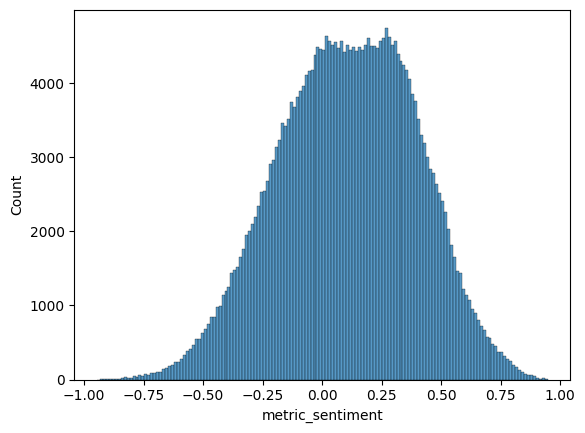

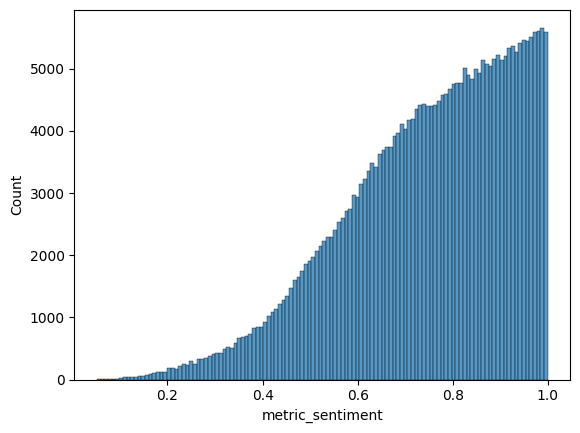

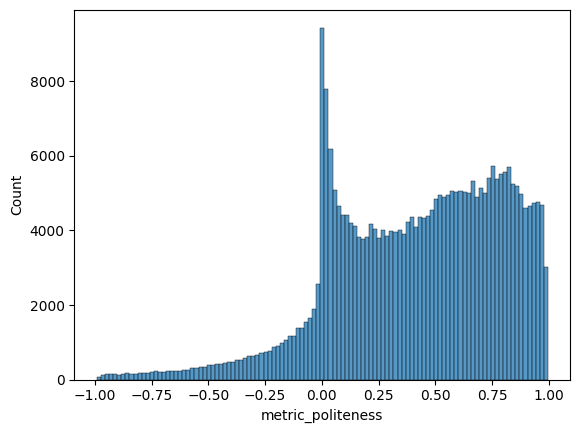

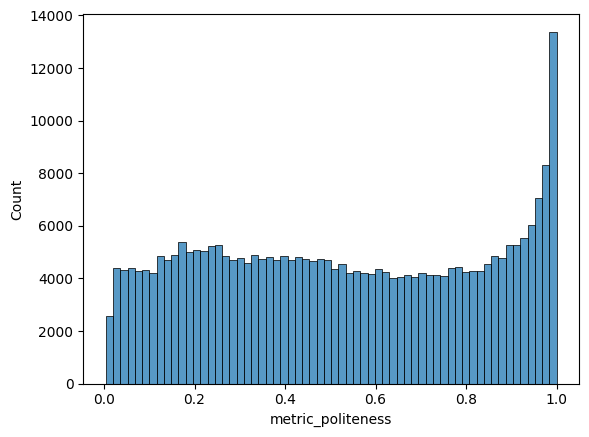

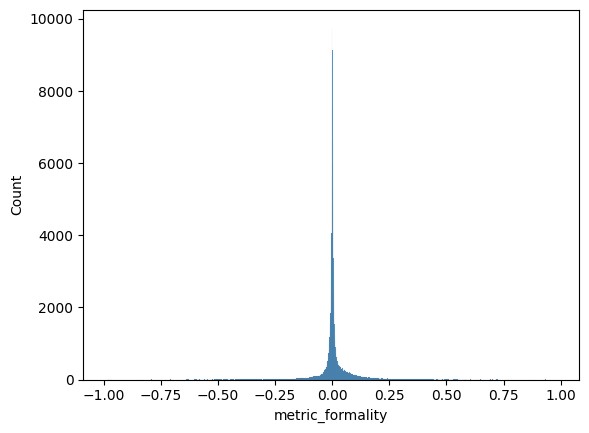

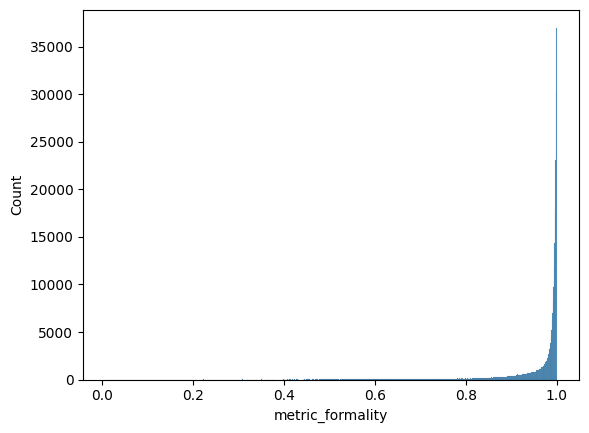

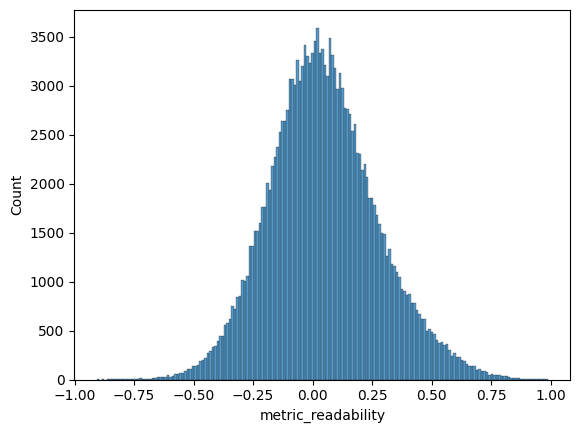

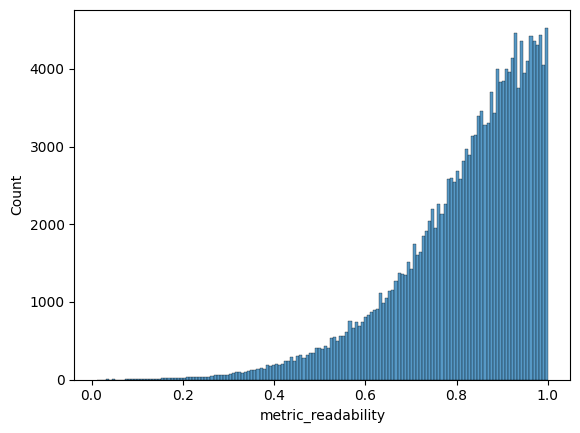

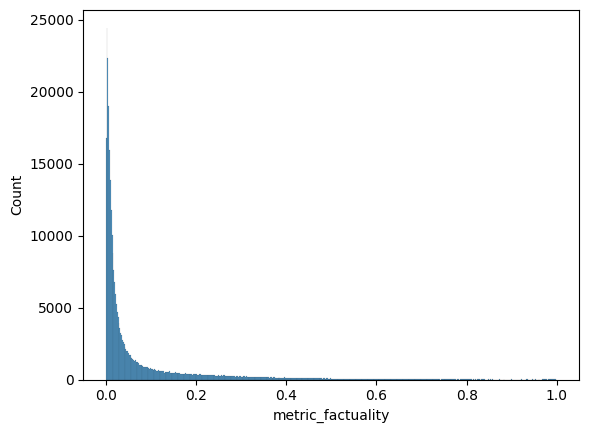

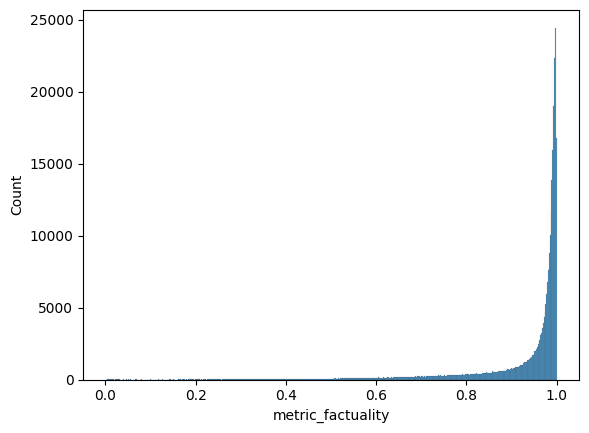

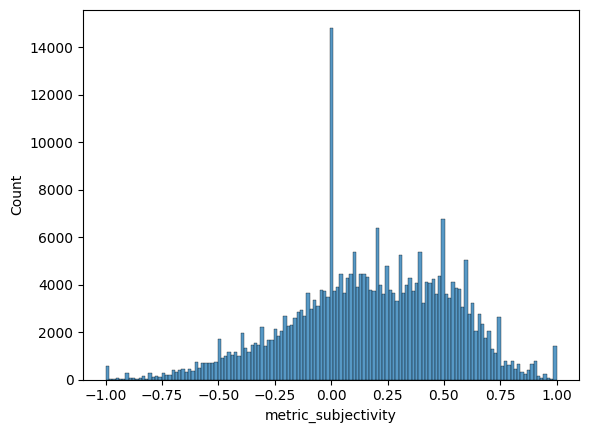

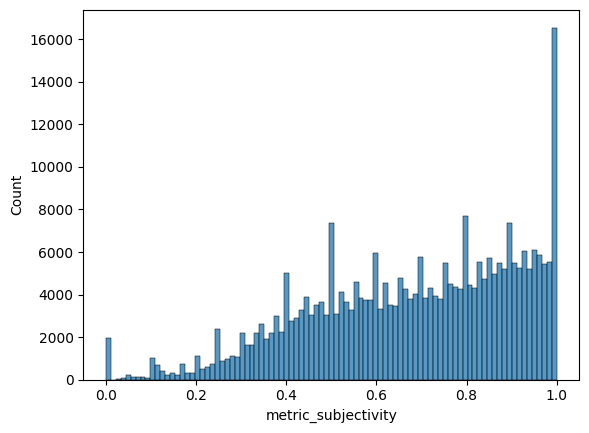

In [25]:
needs_abs_diff = ['metric_perplexity',
                  'metric_typo',
                  'metric_contract_count',
                  'metric_capitalization',
                  'metric_elongation',
                  #'metric_grammar',
                  'metric_sentiment',
                  'metric_politeness',
                  'metric_formality',
                  'metric_toxicity',
                  'metric_readability',
                  'metric_factuality',
                  'metric_subjectivity',
                 ]

for c in needs_abs_diff:
    if c=='metric_toxicity':
        metrics[c] = 1 - np.abs(metrics[c])
    else:
        sns.histplot(metrics[c])
        plt.show()
        metrics[c] = 1 - np.abs(metrics[c])
        sns.histplot(metrics[c])
        plt.show()


In [26]:
'metric_end'

lexical = ['metric_log_word_count',
           'metric_log_word_length',
           'metric_perplexity',
           'metric_typo',
          ]

orthographic = ['metric_capitalization',
                'metric_punctuation',
                'metric_contract_count',
                'metric_elongation',
               ]

syntactic = [#'metric_grammar',
             'metric_pos',
             #'metric_constituency_parse',
            ]

semantic = ['metric_sbert',
            'metric_rouge',
            #'metric_bleu',
            'metric_liwc',
            'metric_topic',
           ]

style = ['metric_sentiment',
         'metric_politeness',
         'metric_formality',
         'metric_toxicity',
         'metric_factuality',
         'metric_readability',
         'metric_subjectivity',
         'metric_luar',
        ]


all_metrics = deepcopy(lexical)
all_metrics.extend(orthographic)
all_metrics.extend(syntactic)
all_metrics.extend(semantic)
all_metrics.extend(style)

<Axes: >

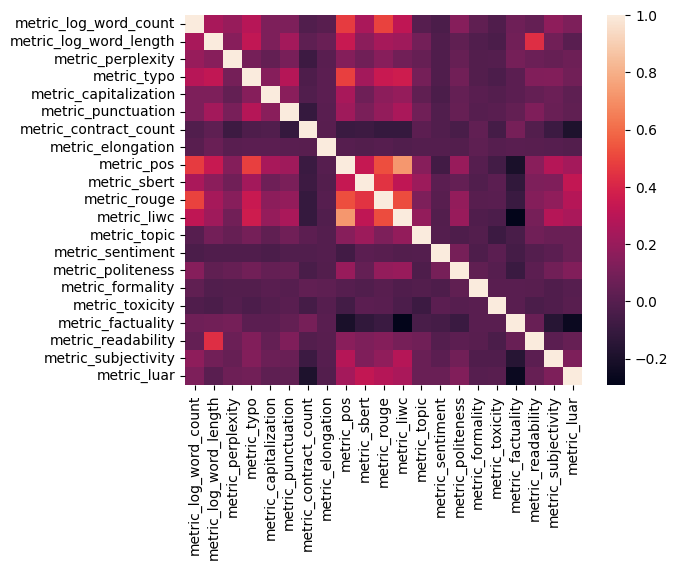

In [27]:
sns.heatmap(metrics[all_metrics].corr())

In [28]:
metrics[lexical]

,metric_log_word_count,metric_log_word_length,metric_perplexity,metric_typo
0,0.969282,0.995550,0.996934,0.943182
1,0.857633,0.967836,0.996349,0.828571
2,0.976737,0.997836,0.973617,0.993506
3,0.933139,0.965042,0.989023,0.900000
4,0.855364,0.911898,0.925381,0.601841
...,...,...,...,...
397172,0.918269,0.996178,0.962921,0.976190
397173,0.886306,0.988536,0.993807,0.987179
397174,0.894027,0.966339,0.974473,0.833333
397175,0.856114,0.949722,0.980629,0.841667


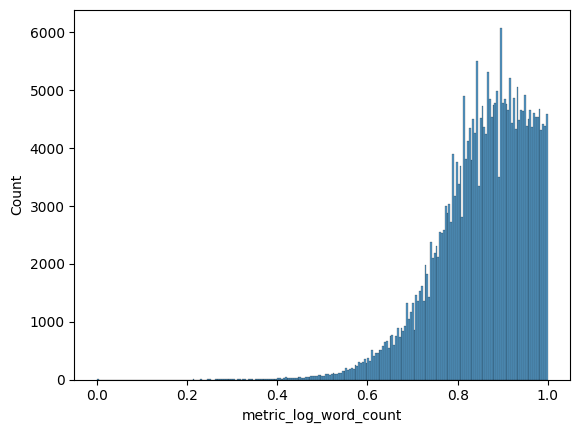

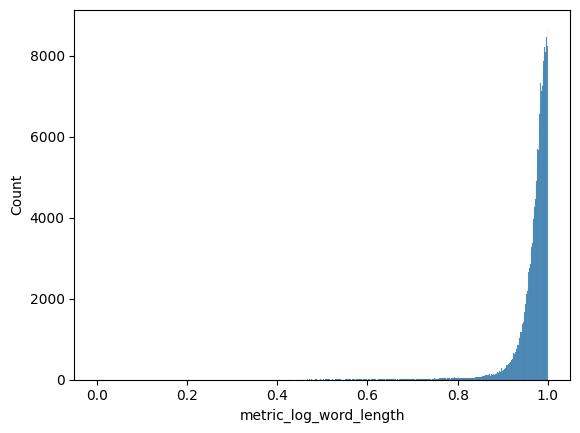

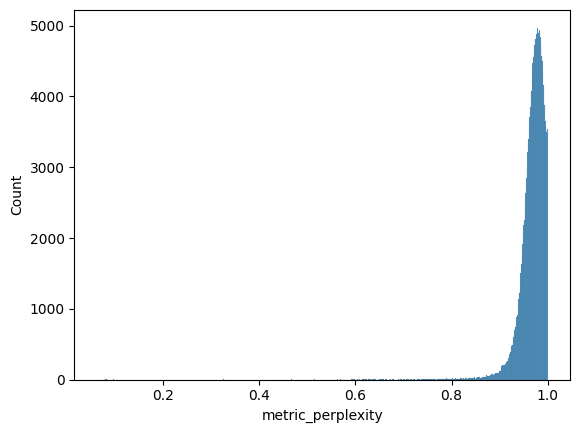

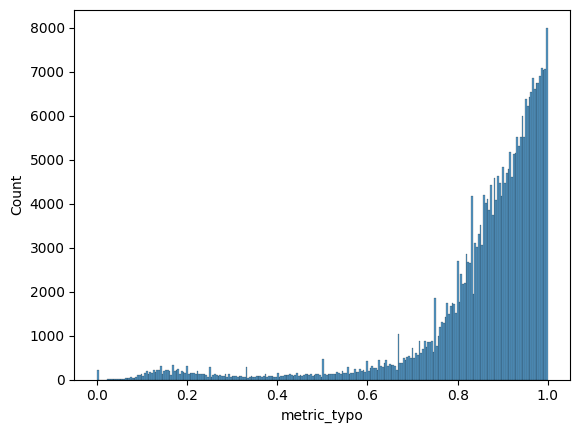

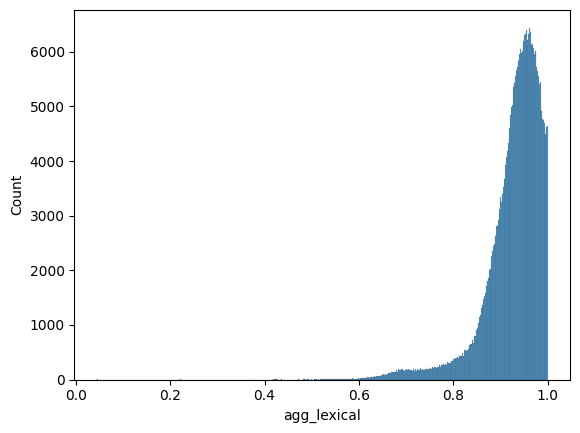

In [29]:
for c in lexical:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_lexical'] = metrics[lexical].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_lexical'])
plt.show()

<Axes: >

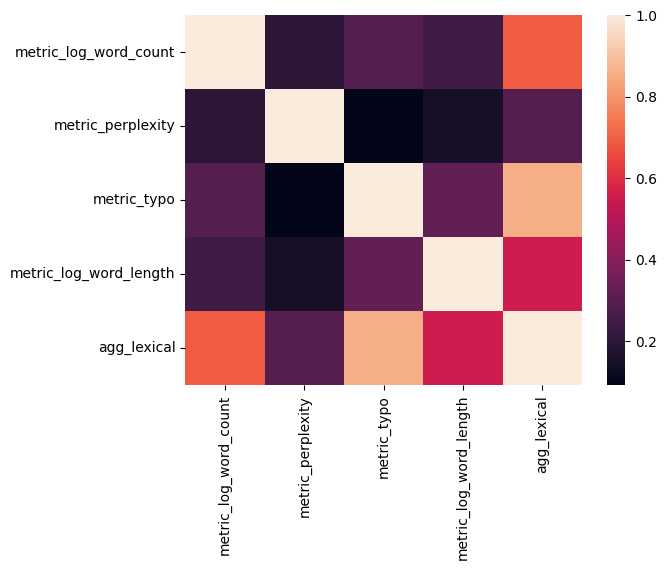

In [30]:
sns.heatmap(metrics[[c for c in metrics.columns if c in lexical or c=='agg_lexical']].corr())

In [31]:
metrics[syntactic]

,metric_pos
0,0.653175
1,0.601523
2,0.617574
3,0.755070
4,0.681584
...,...
397172,0.566117
397173,0.749967
397174,0.676491
397175,0.634389


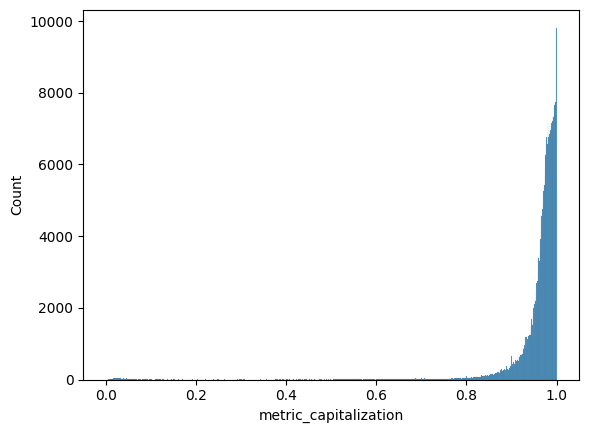

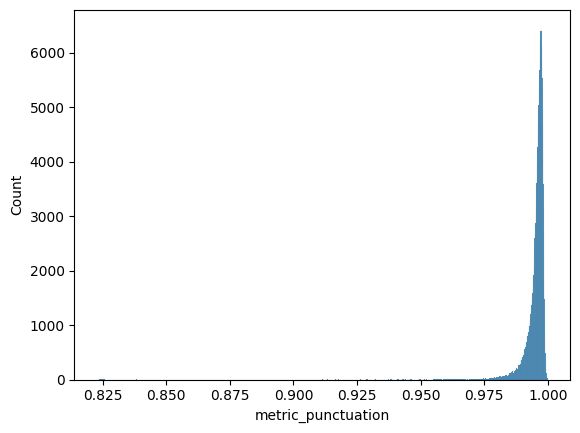

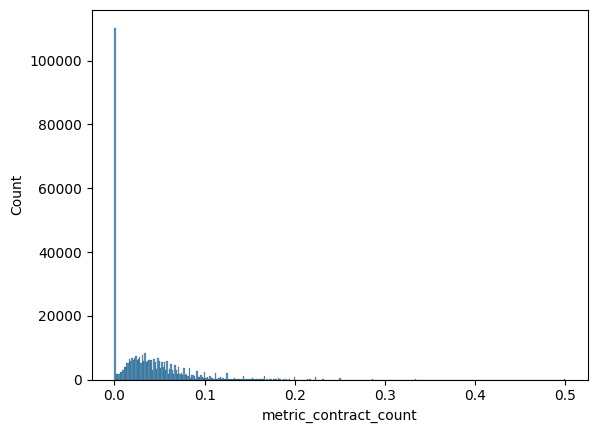

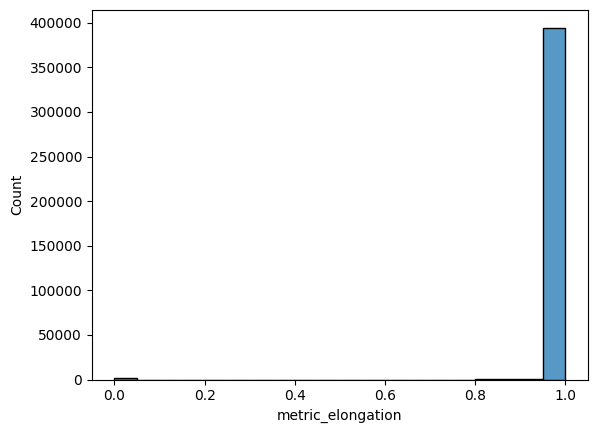

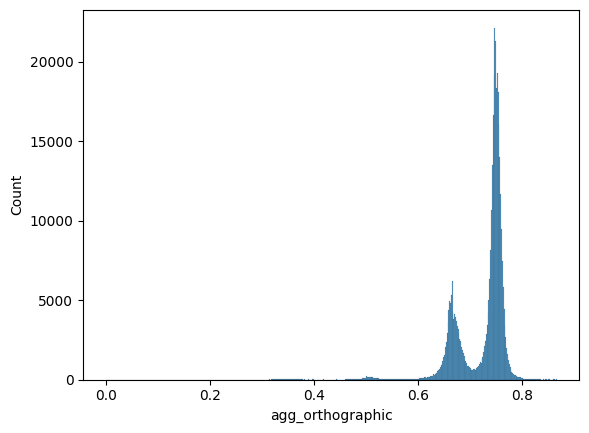

In [32]:
for c in orthographic:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_orthographic'] = metrics[orthographic].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_orthographic'])
plt.show()

<Axes: >

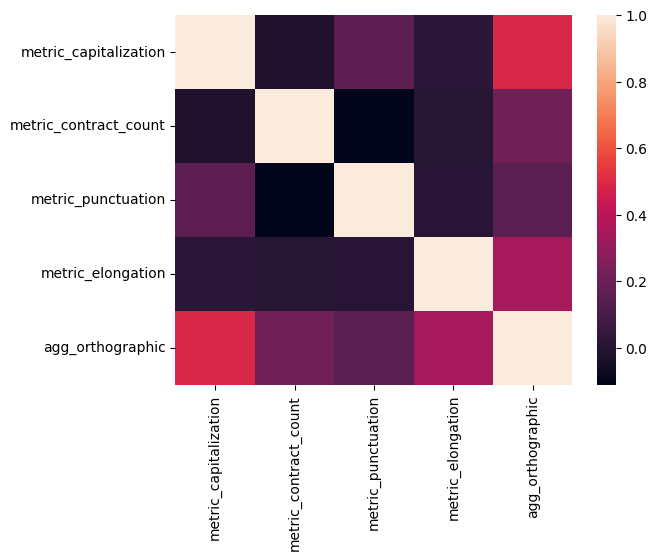

In [33]:
sns.heatmap(metrics[[c for c in metrics.columns if c in orthographic or c=='agg_orthographic']].corr())

In [34]:
metrics[syntactic]

,metric_pos
0,0.653175
1,0.601523
2,0.617574
3,0.755070
4,0.681584
...,...
397172,0.566117
397173,0.749967
397174,0.676491
397175,0.634389


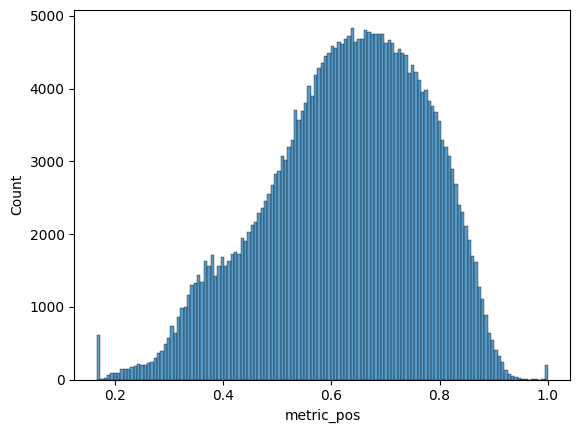

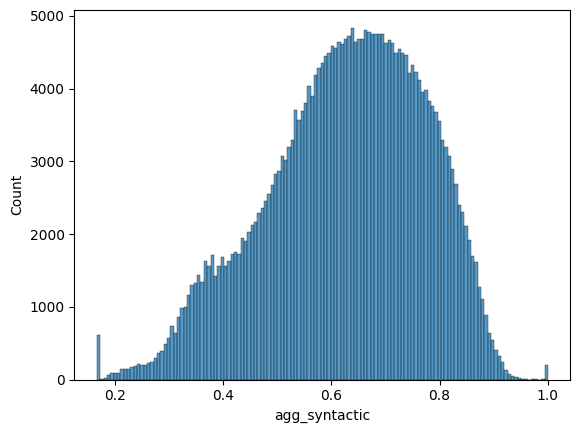

In [35]:
for c in syntactic:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_syntactic'] = metrics[syntactic].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_syntactic'])
plt.show()

<Axes: >

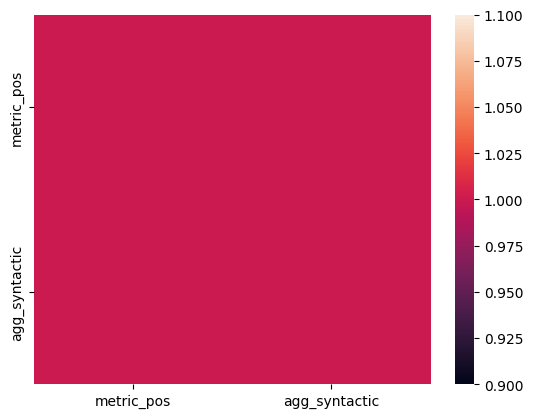

In [36]:
sns.heatmap(metrics[[c for c in metrics.columns if c in syntactic or c=='agg_syntactic']].corr())

In [37]:
metrics[semantic]

,metric_sbert,metric_rouge,metric_liwc,metric_topic
0,0.489480,0.105263,0.405227,0.731681
1,0.496607,0.046512,0.420891,0.869707
2,0.639864,0.120000,0.404632,0.826248
3,0.829827,0.088889,0.538388,0.793457
4,0.530285,0.022814,NaN,0.661320
...,...,...,...,...
397172,0.609093,0.100000,0.337689,0.936496
397173,0.733423,0.117647,0.529612,0.790681
397174,0.486654,0.000000,0.348601,0.888490
397175,0.615388,0.040816,0.574393,0.732890


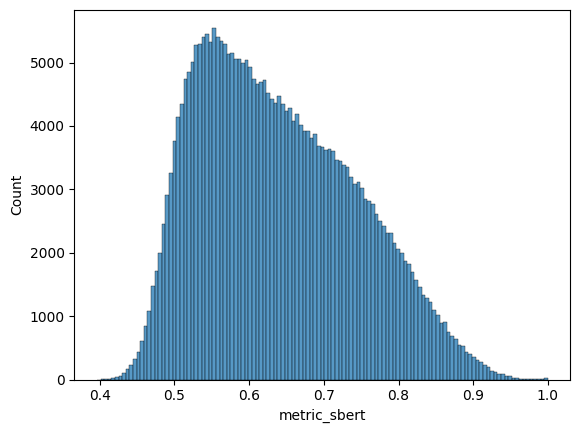

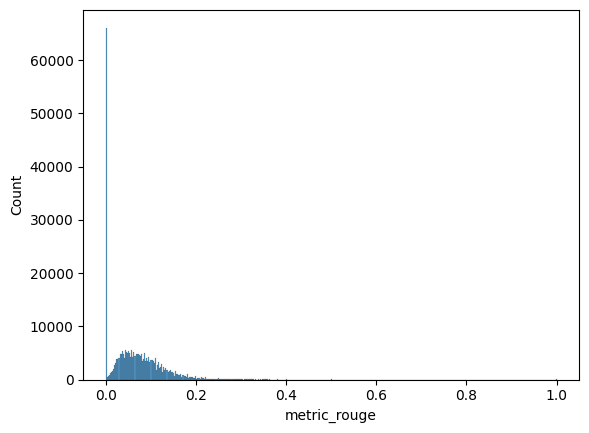

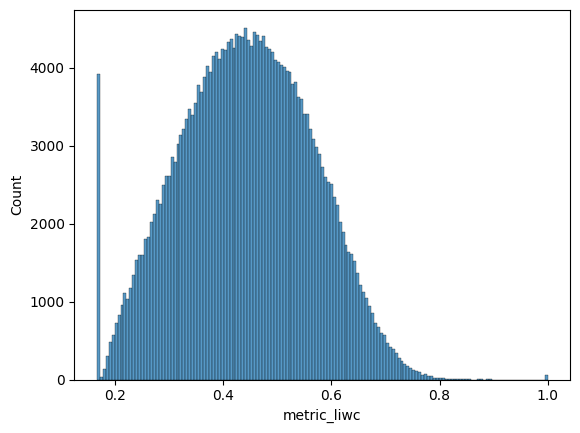

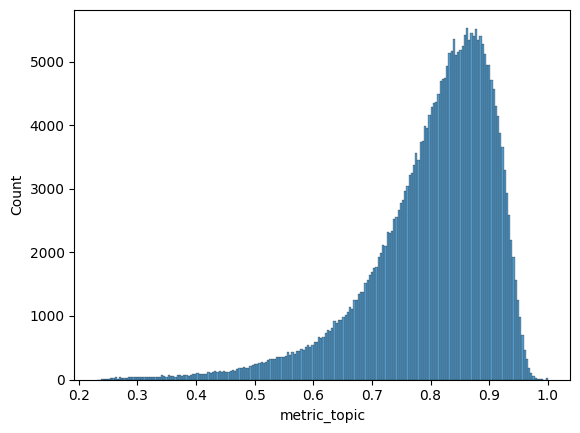

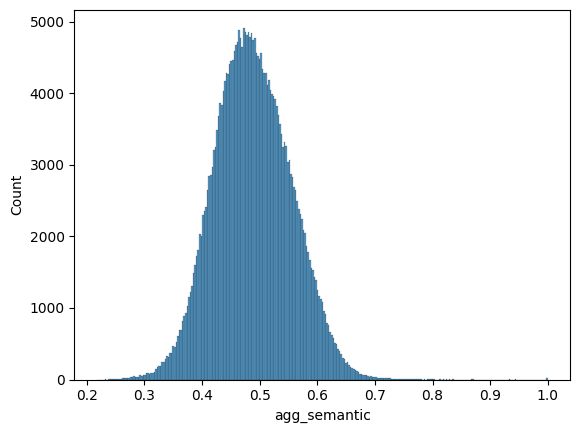

In [38]:
for c in semantic:
    sns.histplot(metrics[c])
    plt.show()

metrics['agg_semantic'] = metrics[semantic].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_semantic'])
plt.show()

<Axes: >

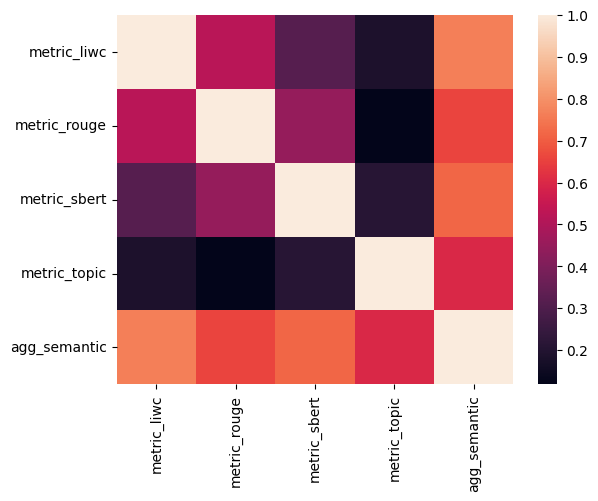

In [39]:
sns.heatmap(metrics[[c for c in metrics.columns if c in semantic or c=='agg_semantic']].corr())

In [40]:
metrics[style]

,metric_sentiment,metric_politeness,metric_formality,metric_toxicity,metric_factuality,metric_readability,metric_subjectivity,metric_luar
0,0.871703,0.721868,0.987958,0.999287,0.998342,NaN,0.400000,0.726307
1,0.756497,0.326744,0.998329,0.999970,0.991923,NaN,0.425000,0.729698
2,0.848500,0.609514,0.482493,0.999995,0.981662,0.900000,0.789262,0.752835
3,0.665717,0.770159,0.980936,1.000000,0.764937,0.630909,0.891667,0.739850
4,0.943010,0.484130,0.997075,0.999999,0.585975,NaN,0.481250,0.858276
...,...,...,...,...,...,...,...,...
397172,0.744736,0.483811,0.052264,0.999994,0.997458,NaN,0.250000,0.702342
397173,0.964531,0.871873,0.993505,0.962260,0.994010,0.798455,0.300000,0.701175
397174,0.965613,0.057037,0.999831,0.999976,0.984237,NaN,0.100000,0.720117
397175,0.941913,0.888853,0.992973,0.999987,0.955307,NaN,0.352814,0.646517


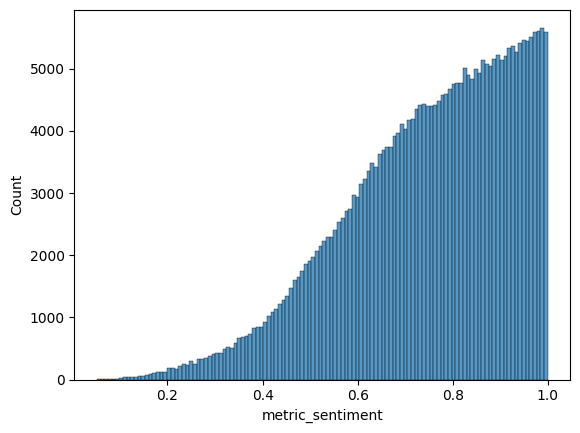

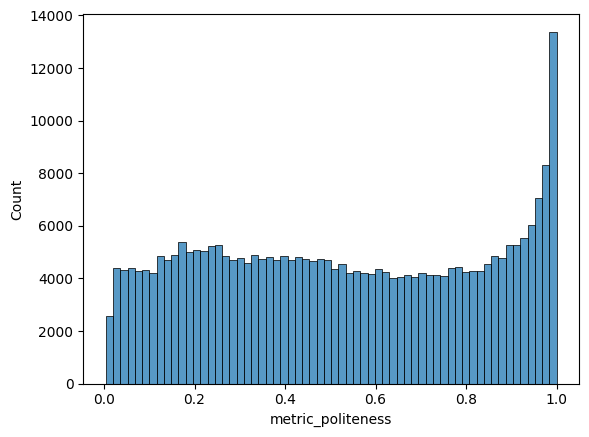

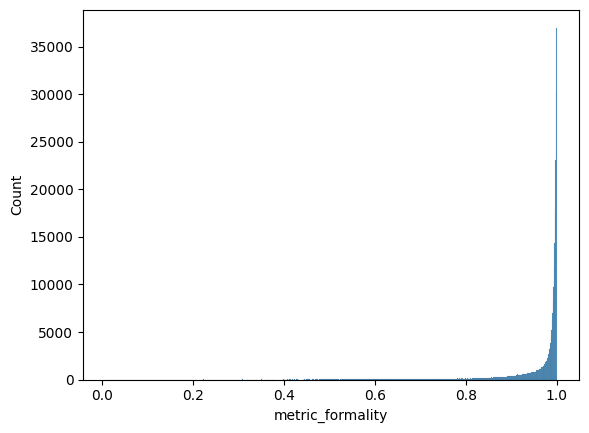

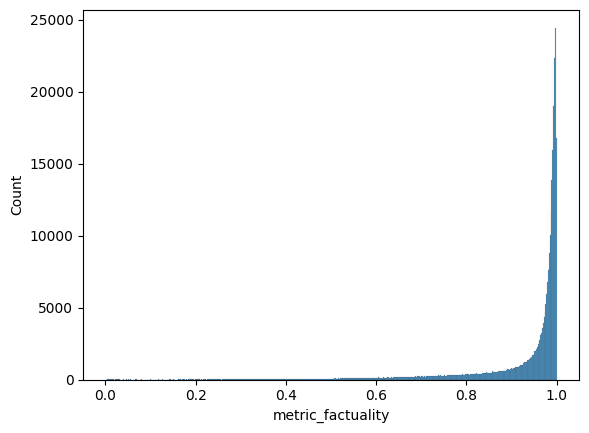

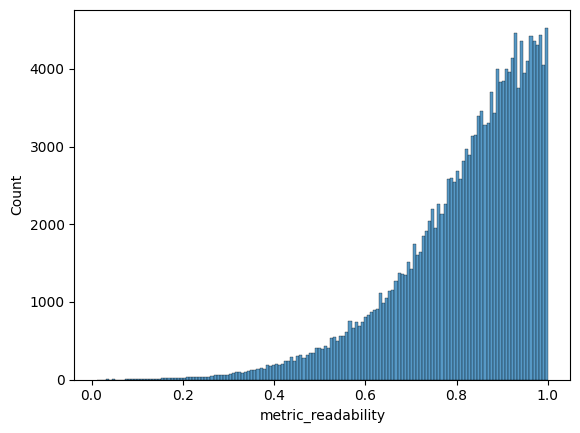

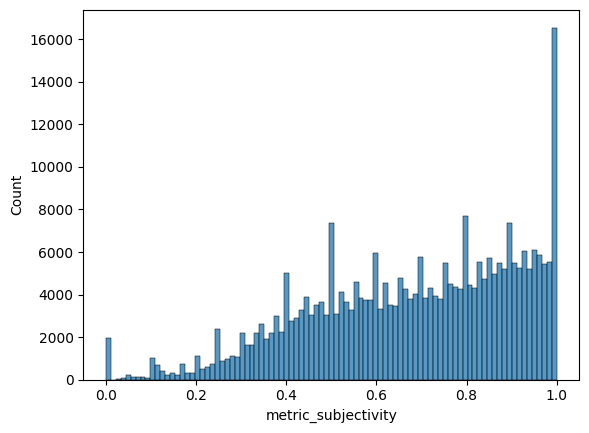

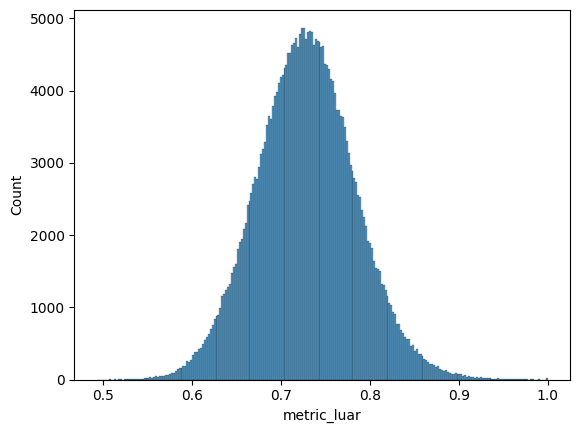

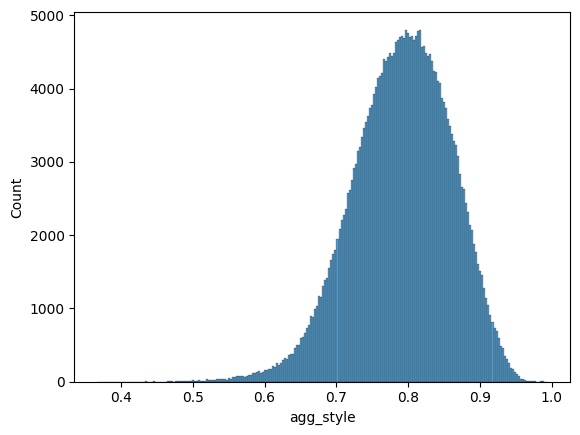

In [41]:
for c in style:
    if c!='metric_toxicity':
        sns.histplot(metrics[c])
        plt.show()

metrics['agg_style'] = metrics[style].apply(lambda x: x.mean(), axis=1)
sns.histplot(metrics['agg_style'])
plt.show()

<Axes: >

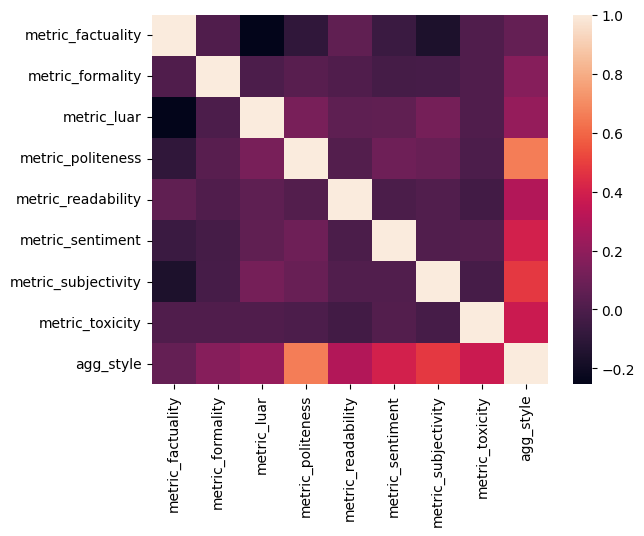

In [42]:
sns.heatmap(metrics[[c for c in metrics.columns if c in style or c=='agg_style']].corr())

<Axes: >

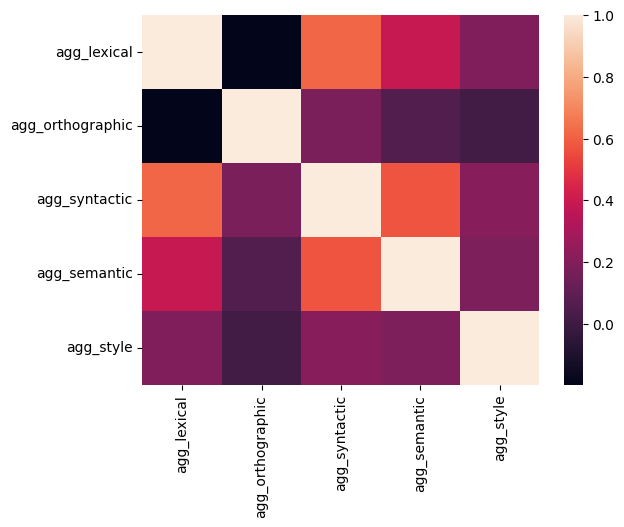

In [43]:
sns.heatmap(metrics[[c for c in metrics.columns if c.startswith('agg_')]].corr())

In [44]:
metrics['overall_score'] = metrics[all_metrics].apply(lambda x: x.mean(), axis=1)


<Axes: >

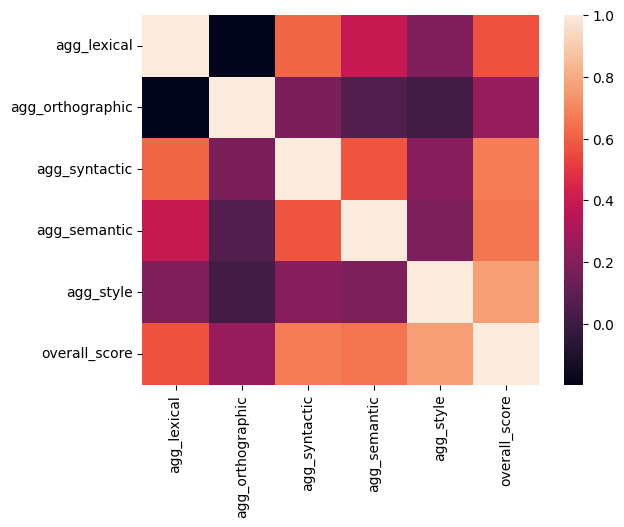

In [45]:
sns.heatmap(metrics[[c for c in metrics.columns if c.startswith('agg_') or c=='overall_score']].corr())

In [ ]:
metrics.to_json('data/wildchat_subset_en_100k_all_normalized_metrics.jsonl', orient='records', lines=True)